# CGAN

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [24]:
nz = 100
embedding_dim = 50
image_size = 28
batch_size = 32
num_epochs = 50
lr = 0.0002
beta1 = 0.5
num_classes = 10
k_d = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# 🎨 Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.fc = nn.Linear(nz + embedding_dim, 128 * 7 * 7)
        self.net = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([z, label_embed], dim=1)
        x = self.fc(x).view(-1, 128, 7, 7)
        return self.net(x)

# 🛡️ Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_img = label_embed.expand(-1, -1, image_size, image_size)
        x = torch.cat([img, label_img[:, :1]], dim=1)
        return self.net(x)

In [ ]:
# 🚀 Init
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# 📈 Metrics
# fid_metric = FrechetInceptionDistance(normalize=True).to(device)
# is_metric = InceptionScore().to(device)

fixed_z = torch.randn(10, nz, device=device)
fixed_labels = torch.arange(0, 10, device=device)


In [ ]:
# 🎯 Training Loop
for epoch in range(num_epochs):
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for i, (imgs, labels) in enumerate(loop):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        real_targets = torch.ones(batch_size, 1, device=device)
        fake_targets = torch.zeros(batch_size, 1, device=device)

        for _ in range(k_d):
            # ---- Train D ----
            z = torch.randn(batch_size, nz, device=device)
            fake_imgs = G(z, labels).detach()

            d_real = D(imgs, labels)
            d_fake = D(fake_imgs, labels)
            d_loss = criterion(d_real, real_targets) + criterion(d_fake, fake_targets)

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # ---- Train G ----
        z = torch.randn(batch_size, nz, device=device)
        fake_imgs = G(z, labels)
        g_loss = criterion(D(fake_imgs, labels), real_targets)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

Epoch [50/50]: 100%|██████████| 1875/1875 [00:44<00:00, 42.58it/s, D_loss=0.019, G_loss=4.53]


In [29]:
G = Generator()
G.load_state_dict(torch.load('c_generator.pth'))
G.to(device)
G.eval()

<ipython-input-29-c1da784e9bbe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('c_generator.pth'))


Generator(
  (label_emb): Embedding(10, 50)
  (fc): Linear(in_features=150, out_features=6272, bias=True)
  (net): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

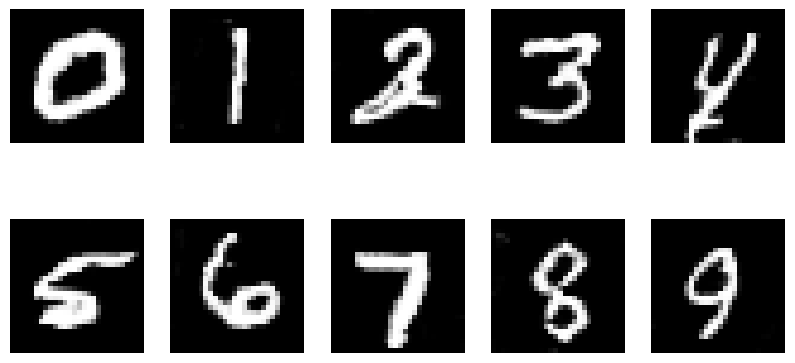

In [30]:
z = torch.randn(10, nz, device=device)
labels = torch.arange(0, 10, device=device)
fake_imgs = G(z, labels)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
  axs[int(i / 5), i % 5].imshow(fake_imgs[i][0].detach().cpu().numpy(), cmap='gray')
  axs[int(i / 5), i % 5].axis('off')
plt.show()

# Contrastive VAE

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class dSpritesDataset(Dataset):
    def __init__(self, path='dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'):
        data = np.load(path, allow_pickle=True, encoding='latin1')
        self.imgs = data['imgs']
        self.latents_values = data['latents_values']
        self.latents_classes = data['latents_classes']

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.tensor(self.imgs[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.latents_classes[idx], dtype=torch.long)
        return img, label

dataset = dSpritesDataset()
train_data, test_data = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*16*16, 128), nn.ReLU(),
            nn.Linear(128, 2*latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, 64*16*16), nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        out = self.encoder(x)
        mu, logvar = out.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, z

In [ ]:
def contrastive_loss(z1, z2, temperature=0.5):
    z1, z2 = F.normalize(z1, dim=1), F.normalize(z2, dim=1)
    batch_size = z1.size(0)
    representations = torch.cat([z1, z2], dim=0)
    similarity = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z1.device)
    similarity = similarity[~mask].view(2*batch_size, -1)

    positives = torch.sum(z1 * z2, dim=-1)
    positives = torch.cat([positives, positives], dim=0)
    nominator = torch.exp(positives / temperature)
    denominator = torch.sum(torch.exp(similarity / temperature), dim=-1)
    loss = -torch.log(nominator / denominator)
    return loss.mean()

In [ ]:
from tqdm import tqdm

device = 'cuda'
vae = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

for epoch in range(10):
    loop = tqdm(loader, desc=f"Epoch [{epoch+1}/10]")
    for x, _ in loop:
        x1, x2 = x.to(device), x.clone().to(device)
        x1_recon, mu1, logvar1, z1 = vae(x1)
        x2_recon, mu2, logvar2, z2 = vae(x2)
        L_vae = vae_loss(x1_recon, x1, mu1, logvar1)
        L_contrast = contrastive_loss(z1, z2)
        loss = L_vae + 0.1 * L_contrast

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

Epoch [10/10]: 100%|██████████| 23040/23040 [04:28<00:00, 85.74it/s, loss=1.5e+3]


In [ ]:
torch.save(vae.state_dict(), 'contrastive_vae.pt')

In [4]:
device = 'cuda'
vae = VAE(latent_dim=20).to(device)
vae.load_state_dict(torch.load('contrastive_vae.pt'))
vae.eval()

<ipython-input-4-2c6570ccd298>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('contrastive_vae.pt'))


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=16384, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 16, 16))
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
from torchsummary import summary
summary(vae, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             544
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,832
              ReLU-4           [-1, 64, 16, 16]               0
           Flatten-5                [-1, 16384]               0
            Linear-6                  [-1, 128]       2,097,280
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 40]           5,160
            Linear-9                  [-1, 128]           2,688
             ReLU-10                  [-1, 128]               0
           Linear-11                [-1, 16384]       2,113,536
             ReLU-12                [-1, 16384]               0
        Unflatten-13           [-1, 64, 16, 16]               0
  ConvTranspose2d-14           [-1, 32,

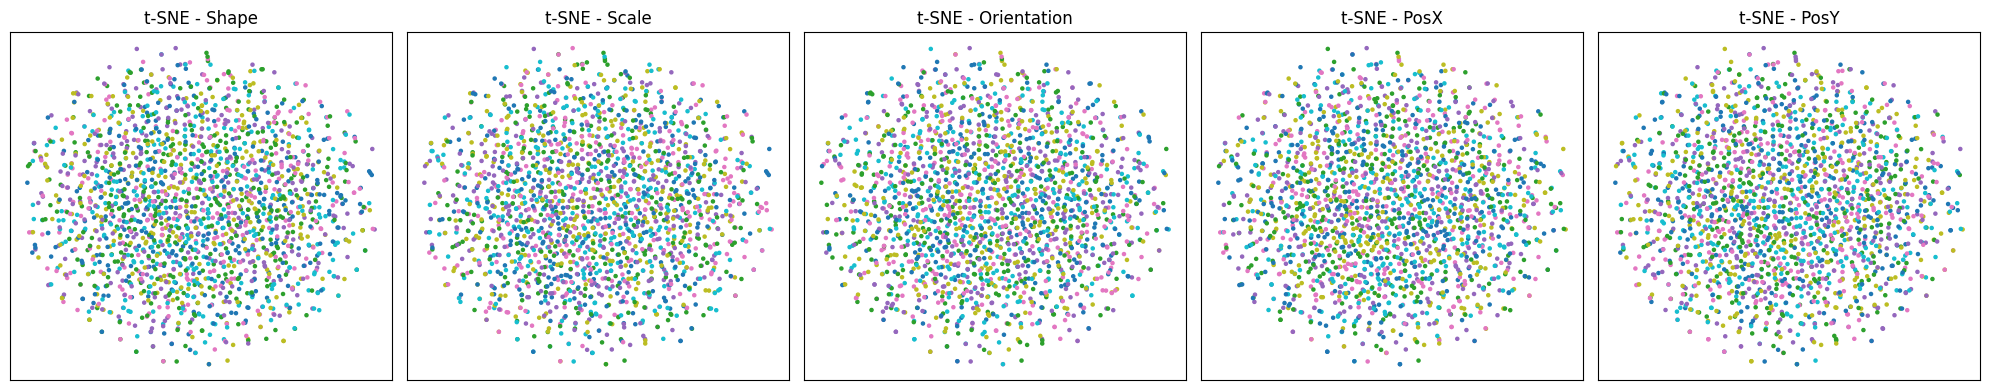

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP

# Assuming Z shape: (N, latent_dim), Y shape: (N, num_factors)
latent_dim = 20
num_samples = 2000
Z = torch.normal(0,1,(num_samples, latent_dim))
Y = np.random.randint(0, 6, size=(num_samples, 5))  # 5 factors (shape, scale, orientation, posX, posY)

# 1. t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=0)
Z_tsne = tsne.fit_transform(Z)

# 2. UMAP visualization
# umap = UMAP(n_components=2, random_state=0)
# Z_umap = umap.fit_transform(Z)

# Plotting function
def plot_latents(Z_proj, Y, title):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    factor_names = ['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']
    for i in range(5):
        axs[i].scatter(Z_proj[:, 0], Z_proj[:, 1], c=Y[:, i], cmap='tab10', s=5)
        axs[i].set_title(f"{title} - {factor_names[i]}")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.tight_layout()
    plt.show()

plot_latents(Z_tsne, Y, "t-SNE")
# plot_latents(Z_umap, Y, "UMAP")


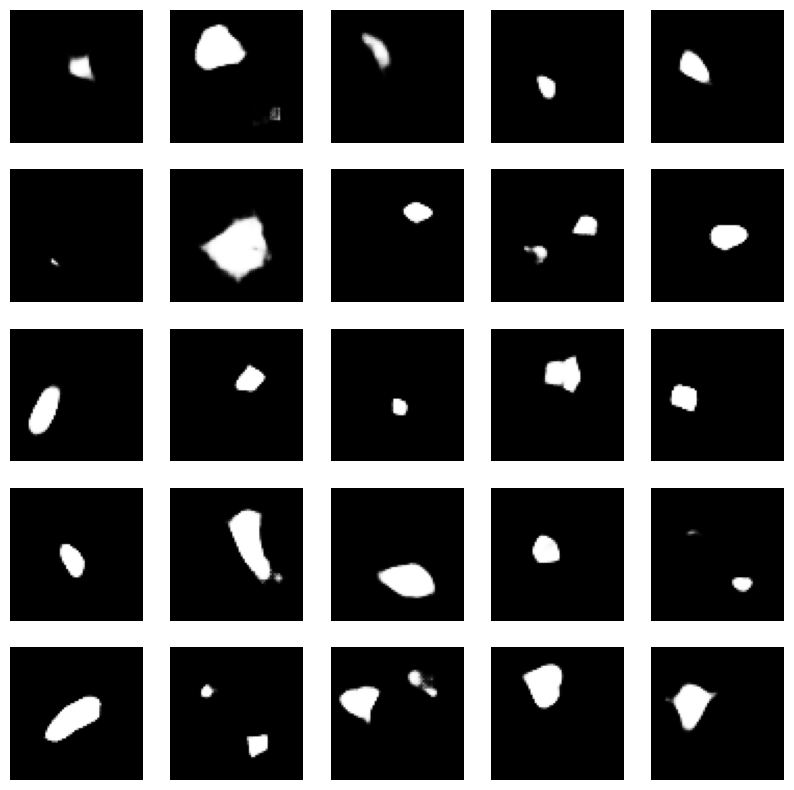

In [ ]:
images = vae.decoder(Z.to(device))
# print(images.shape)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
  axs[int(i / 5), i % 5].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[int(i / 5), i % 5].axis('off')
plt.show()

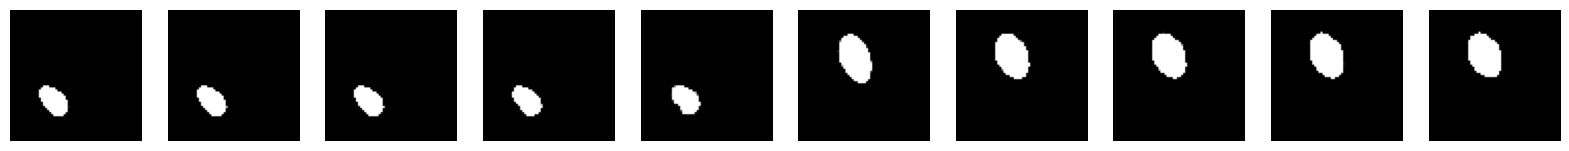

In [6]:
torch.seed()
latent_dim = 20
latents = torch.normal(0,1, (1, latent_dim)).to(device)
n = 10
latents = latents.repeat(n, 1)
latents[:, 6] = torch.linspace(-100, 100, n)
images = vae.decoder(latents)
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

**Observation**
* As it can be observed the size and position is changing when changing a particular feature (7th feature here)

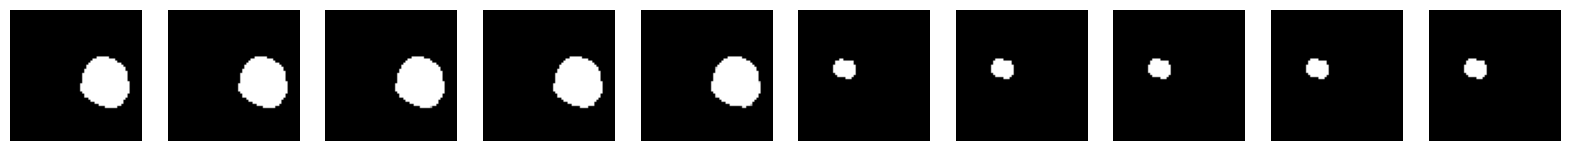

In [7]:
latents[:, 19] = torch.linspace(-1000, 1000, n)
images = vae.decoder(latents)
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

* Here the shape is changed, size is decreasing and position is shifting to right

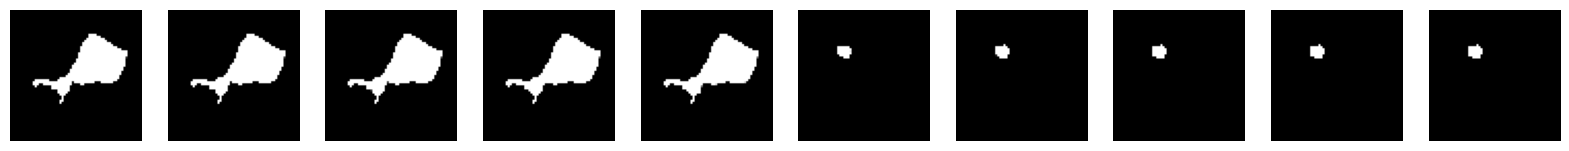

In [10]:
latents[:, 17] = torch.linspace(-1000, 1000, n)
images = vae.decoder(latents)
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

In [ ]:
from tqdm import tqdm

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae_normal = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(vae_normal.parameters(), lr=1e-3)
vae_normal.train()
for epoch in range(10):
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/10]")
    for x, _ in loop:
        x1 = x.to(device)
        x1_recon, mu1, logvar1, z1 = vae_normal(x1)
        # x2_recon, mu2, logvar2, z2 = vae(x2)
        L_vae = vae_loss(x1_recon, x1, mu1, logvar1)
        # L_contrast = contrastive_loss(z1, z2)
        loss = L_vae

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

Epoch [10/10]: 100%|██████████| 18432/18432 [02:15<00:00, 136.31it/s, loss=1.64e+3]


In [ ]:
torch.save(vae_normal.state_dict(), 'vae_normal.pt')

In [11]:
vae_normal = VAE(latent_dim=20).to(device)
vae_normal.load_state_dict(torch.load('vae_normal.pt'))
vae_normal.eval()

<ipython-input-11-5802932434a3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_normal.load_state_dict(torch.load('vae_normal.pt'))


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=16384, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 16, 16))
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Sigmoid()
  )
)

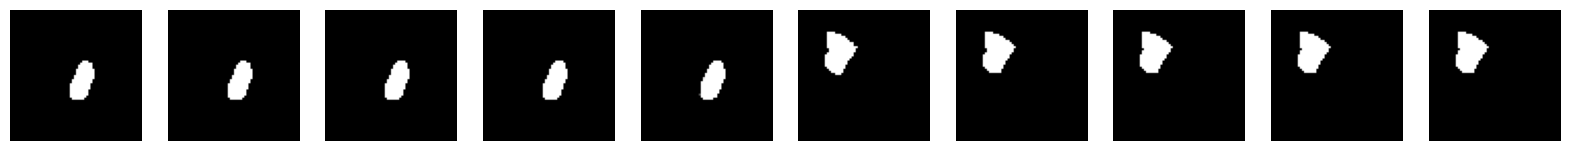

In [12]:
latents[:, 11] = torch.linspace(-1000, 1000, n)
images = vae_normal.decoder(latents.to(device))
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

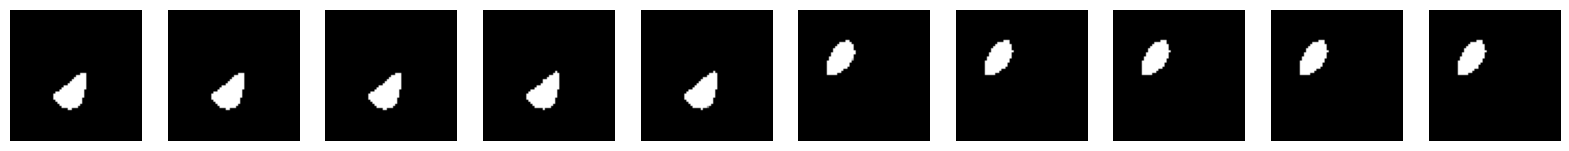

In [20]:
latents[:, 19] = torch.linspace(-1000, 1000, n)
images = vae_normal.decoder(latents.to(device))
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

* The VAE without contrastive loss have to accomodate a greater change as compared to the VAE trained with constrastive loss. Also, most of the features in latent space are not diverse in case of former.

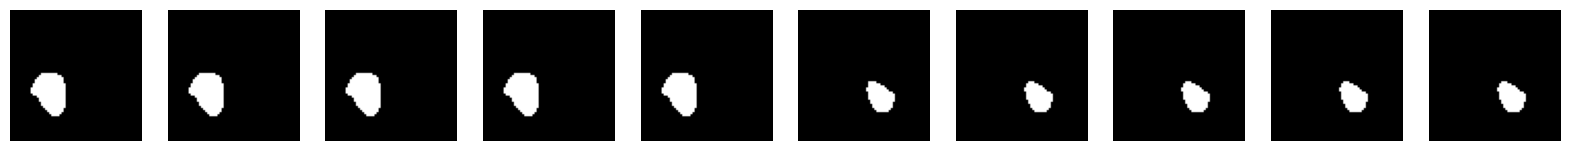

In [22]:
latents[:, 19] = torch.linspace(-100, 100, n)
images = vae.decoder(latents.to(device))
fig, axs = plt.subplots(1, n, figsize=(20, 15))
for i in range(n):
  axs[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
  axs[i].axis('off')

In [4]:
images = [dataset[i][0] for i in range(100)]
images = torch.concatenate(images).unsqueeze(1)

In [8]:
sum = 0
i = 0
def cosine_similarity(I1, I2):
  dot = torch.sum(I1 * I2)
  norm_I1 = torch.norm(I1)
  norm_I2 = torch.norm(I2)
  return dot / (norm_I1 * norm_I2)


def get_embeddings(model, img):
  with torch.no_grad():
    enc = model.encoder(img.unsqueeze(0).to(device))
    mu, logvar = enc.chunk(2, dim=1)
    z = model.reparameterize(mu, logvar)
    return z

for i in range(100):
  for j in range(i + 1, 100):
    l1 = dataset[i][1]
    l2 = dataset[j][1]
    if l1.any() == l2.any():
      continue
    z1 = get_embeddings(vae, images[i])
    z2 = get_embeddings(vae, images[j])

    sum += cosine_similarity(z1, z2)
    i += 1

print("Cosine Similarity of Contrastive VAE: ", sum.item() / i)

Cosine Similarity of Contrastive VAE:  0.006666794569805415


In [9]:
vae_normal = VAE(latent_dim=20).to(device)
vae_normal.load_state_dict(torch.load('vae_normal.pt'))
vae_normal.eval()

for i in range(100):
  for j in range(i+1, 100):
    l1 = dataset[i][1]
    l2 = dataset[j][1]
    if l1.any() == l2.any():
      continue
    z1 = get_embeddings(vae_normal, images[i])
    z2 = get_embeddings(vae_normal, images[j])

    sum += cosine_similarity(z1, z2)
    i += 1

print("Cosine Similarity of Normal VAE: ", sum.item() / i)

Cosine Similarity of Normal VAE:  0.012865957587656348
